<strong><font size="8">A4</font></strong>

In [37]:
from pathlib import Path
import re
import warnings

import numpy as np
import scipy# import stats
import eelbrain
import mne
import seaborn
from matplotlib import pyplot as plt

# Define some paths that will be used throughout
DATA_ROOT = Path("~").expanduser() / 'Data' / 'Alice'
STIMULUS_DIR = DATA_ROOT / 'stimuli'
EEG_DIR = DATA_ROOT / 'eeg'

# General parameters
LOW_FREQUENCY = 0.5
HIGH_FREQUENCY = 20
SAMPLINGRATE = 50

mne.set_log_level('WARNING')  # supresses most useless outputs

# Suppress warning on low pass filter
warnings.filterwarnings("ignore", category=RuntimeWarning, message="The measurement information indicates a low-pass frequency of 20.0 Hz.*")

<strong><font size="6">1</font></strong>

In [38]:
#----------------------# SETUP #----------------------#
SUBJECTS = [path.name for path in EEG_DIR.iterdir() if path.name.startswith('S')]

# Define latency windows
RANGES = [(i/10, (i+1)/10) for i in range(6)]
# Add some latencies further out
RANGES.append((0.9, 1.0))
RANGES.append((1.9, 2.0))

#----------------------# GENERATE ENVELOPE #----------------------#
envelopes = {}
for stimulus_id in range(1, 13):
    wav = eelbrain.load.wav(STIMULUS_DIR / f'{stimulus_id}.wav')
    envelope = wav.envelope()
    envelope = eelbrain.filter_data(envelope, LOW_FREQUENCY, HIGH_FREQUENCY, pad='reflect')
    envelope = eelbrain.resample(envelope, SAMPLINGRATE)
    envelopes[f'{stimulus_id}'] = envelope

In [40]:
#----------------------# TRF #----------------------#

# Container for collecting decoders
decoders = {}
  
# Loop through subjects
for subject in SUBJECTS[:]:
    # Load the subject's data
    raw = mne.io.read_raw(EEG_DIR / subject / f'{subject}_alice-raw.fif', preload=True)
    raw.filter(LOW_FREQUENCY, HIGH_FREQUENCY, n_jobs=1)
    events = eelbrain.load.mne.events(raw)
    
    # Add the envelopes corresponding to the trials
    events['envelope'] = [envelopes[stimulus_id] for stimulus_id in events['event']]
    # Extract the stimulus duration (in seconds) from the envelopes
    events['duration'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']])
    # extract EEG data corresponding exactly to the timing of the envelopes
    events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=10, connectivity='auto')
    # identifies onsets within the envelope, by taking positive sudden changes and creating a 2nd predictor
    events['onsets'] = [envelopes[stimulus_id].diff('time', name = 'onsets').clip(0) for stimulus_id in events['event']]
    
    # Train decoders for this subject 
    decoders[subject] = {}
    for tstart, tstop in RANGES:
        envelopeModel = eelbrain.boosting(x='envelope', y='eeg', tstart=-tstop, tstop=-tstart, partitions=4, data=events, delta=0.05, test=True)
        onsetModel = eelbrain.boosting(x='onsets', y='eeg', tstart=-tstop, tstop=-tstart, partitions=4, data=events, delta=0.05, test=True)
        fullModel = eelbrain.boosting(x=['envelope', 'onsets'], y='eeg', tstart=-tstop, tstop=-tstart, partitions=4, data=events, delta=0.05, test=True)
        
        decoders[subject][tstart] = {'envelope': envelopeModel, 'onset': onsetModel, 'full': fullModel}


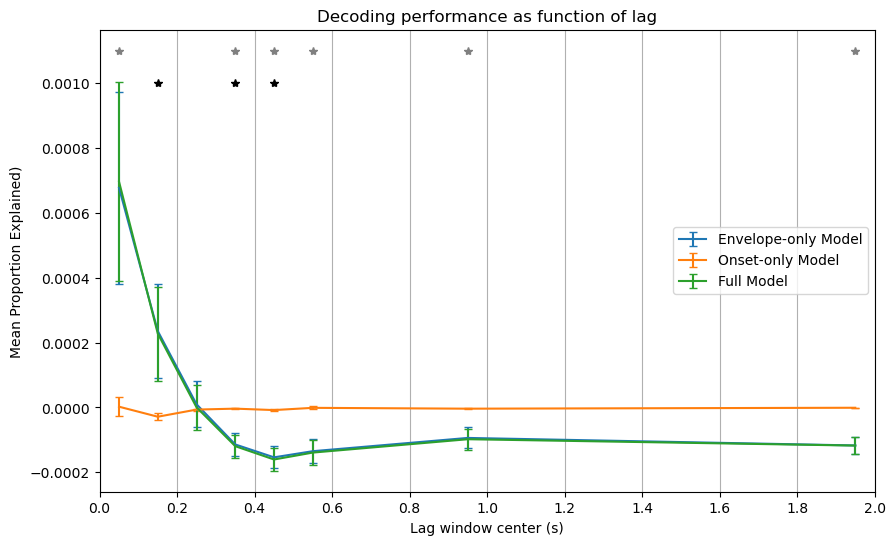

T-stats, Envelope vs, Full: [-1.68594518  2.29783618  1.88334591  2.30140315  2.33696446  1.79147462
  1.71804795  0.22628741]
P-values, Envelope vs. Full: [0.10153461 0.02825675 0.06876966 0.02803034 0.02586115 0.08267962
 0.09545133 0.82241713] 

T-stats, Onset vs. Full: [-2.41846669 -1.68100245 -0.10071599  3.2194109   4.59969489  3.71271904
  2.92278037  4.39269534]
P-values, Onset vs Full: [2.14520906e-02 1.02499364e-01 9.20404309e-01 2.94283736e-03
 6.33588926e-05 7.79168057e-04 6.31989942e-03 1.14869186e-04]


In [41]:
#----------------------# T-TEST #----------------------#
# Extract decoding performance 
envelopeRows = []
onsetRows = []
fullRows = []

for subject in SUBJECTS:
    envelopeRow = []
    onsetRow = []
    fullRow = []
    
    for tstart, tstop in RANGES:
        envelopeRow.append(decoders[subject][tstart]['envelope'].proportion_explained.mean())
        onsetRow.append(decoders[subject][tstart]['onset'].proportion_explained.mean())
        fullRow.append(decoders[subject][tstart]['full'].proportion_explained.mean())
    
    envelopeRows.append(envelopeRow)
    onsetRows.append(onsetRow)
    fullRows.append(fullRow)

# Subject x latency matrix
envelopeData = np.array(envelopeRows)
onsetData = np.array(onsetRows)
fullData = np.array(fullRows)

# Calculate t-statistics between the full and partial data
ttestEnvelope = scipy.stats.ttest_rel(envelopeData, fullData, axis=0, nan_policy='omit') # impact of the ONSET
ttestOnset = scipy.stats.ttest_rel(onsetData, fullData, axis=0, nan_policy='omit') # impact of the ENVELOPE


#----------------------# PLOTTING #----------------------#
# Plot decoding performance as function of lag
x = [(tstart + tstop) / 2 for tstart, tstop in RANGES]

# Mean across subjects
envelopeMean = envelopeData.mean(0)
onsetMean = onsetData.mean(0)
fullMean = fullData.mean(0)

# Error across subjects
envelopeErr = scipy.stats.sem(envelopeData, axis=0, nan_policy='omit')
onsetErr = scipy.stats.sem(onsetData, axis=0, nan_policy='omit')
fullErr = scipy.stats.sem(fullData, axis=0, nan_policy='omit')

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(x, envelopeMean, yerr=envelopeErr, label='Envelope-only Model', capsize=3)
plt.errorbar(x, onsetMean, yerr=onsetErr, label='Onset-only Model', capsize=3)
plt.errorbar(x, fullMean, yerr=fullErr, label='Full Model', capsize=3)

# Significant (p < 0.05) time-points
for i, xi in enumerate(x):
    if ttestEnvelope.pvalue[i] < 0.05:
        plt.plot(xi, 0.001, marker='*', color='black') # shows where the ONSET has significance
    if ttestOnset.pvalue[i] < 0.05:
        plt.plot(xi, 0.0011, marker='*', color='gray') # shows where the ENVELOPE has significance

plt.xticks(np.arange(0, 2.1, 0.200))
plt.grid(axis='x')
plt.ylabel('Mean Proportion Explained)')
plt.xlabel('Lag window center (s)')
plt.xlim(RANGES[0][0], RANGES[-1][1])
plt.title("Decoding performance as function of lag")
plt.legend()
plt.show()


# Printing t-statistics and p-values
print("T-stats, Envelope vs, Full:", ttestEnvelope[0])
print("P-values, Envelope vs. Full:", ttestEnvelope[1], "\n")

print("T-stats, Onset vs. Full:", ttestOnset[0])
print("P-values, Onset vs Full:", ttestOnset[1])

As can be seen by the grey (ENVELOPE) and black (ONSET) stars in the graph, both the envelope and onset provide statistically-significant value to the model. This means that both the acoustic power and acoustic edges are valuable in determining the brain's activity. However, the envelope is MUCH more useful, as can be seeen in graph when looking at the envelope-only model and the full model. It nearly identically follows the full model, and for any time above 300ms the envelope heavily takes over. The onset aids in the early-mid latency windows, betweeen 100 and 500ms. 

Therefore, while we have different part showing statistical significance in both the onset and envelope models, the envelope model contributes to most of determination of the brain activity especially in the later time windows, and the onset model contributes to some extent between 100 and 500ms.

<strong><font size="6">2</font></strong>

In [42]:
PREDICTOR_DIR = DATA_ROOT / 'predictors'

#----------------------# GENERATE ENVELOPES AND ONSETS #----------------------#
cochleagramEnvelopes = {}
cochleagramOnsets = {}

for stimulus_id in range(1, 13):
    envelopeList = eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus_id}~gammatone-1')
    onsetList = eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus_id}~gammatone-on-1.pickle')
    
    envelope = eelbrain.filter_data(envelope, LOW_FREQUENCY, HIGH_FREQUENCY, pad='reflect')
    onset = eelbrain.filter_data(onset, LOW_FREQUENCY, HIGH_FREQUENCY, pad='reflect')
    
    envelope = eelbrain.resample(envelope, SAMPLINGRATE)
    onset = eelbrain.resample(onset, SAMPLINGRATE)

    cochleagramEnvelopes[str(stimulus_id)] = envelope
    cochleagramOnsets[str(stimulus_id)] = onset

In [43]:
#----------------------# TRF W/ COCHLEAGRAM #----------------------#

cochleagramDecoders = {}

for subject in SUBJECTS[:]:
    raw = mne.io.read_raw(EEG_DIR / subject / f'{subject}_alice-raw.fif', preload=True)
    raw.filter(LOW_FREQUENCY, HIGH_FREQUENCY, n_jobs=1)
    events = eelbrain.load.mne.events(raw)

    # Add cochleagram envelopes and onsets
    events['cochEnvelope'] = [ eelbrain.load.unpickle(DATA_ROOT / 'predictors' / f"{stim_id}~gammatone-1.pickle") for stim_id in events['event']]
    events['cochOnset'] = [eelbrain.load.unpickle(DATA_ROOT / 'predictors' / f"{stim_id}~gammatone-on-1.pickle") for stim_id in events['event']]    
    events['duration'] = eelbrain.Var([env.time.tstop for env in events['cochEnvelope']])
    events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=10, connectivity='auto')

    # Resample to 50Hz cause otherwise it breaks everything. Finds sample rate, resamples each individually
    events['cochEnvelope'] = [eelbrain.resample(env, 1. / eeg.time.tstep) for env, eeg in zip(events['cochEnvelope'], events['eeg'])]
    events['cochOnset'] = [eelbrain.resample(on, 1. / eeg.time.tstep) for on, eeg in zip(events['cochOnset'], events['eeg'])]

    # Train decoders for this subject 
    cochleagramDecoders[subject] = {}
    for tstart, tstop in RANGES:
        fullModel = eelbrain.boosting(x=['cochEnvelope', 'cochOnset'], y='eeg', tstart=-tstop, tstop=-tstart, partitions=4, data=events, delta=0.05, test=True)

        cochleagramDecoders[subject][tstart] = {'full': fullModel}


T-stats, Waveform vs. Cochleagram: [-2.36308957 -2.2051892  -1.91967371 -1.1530172   0.43734578  2.84404368
  1.95934505  2.31174487]
P-values, Waveform vs. Cochleagram: [0.02436564 0.03474515 0.06385237 0.25744362 0.66479812 0.00770104
 0.05883275 0.02738316]


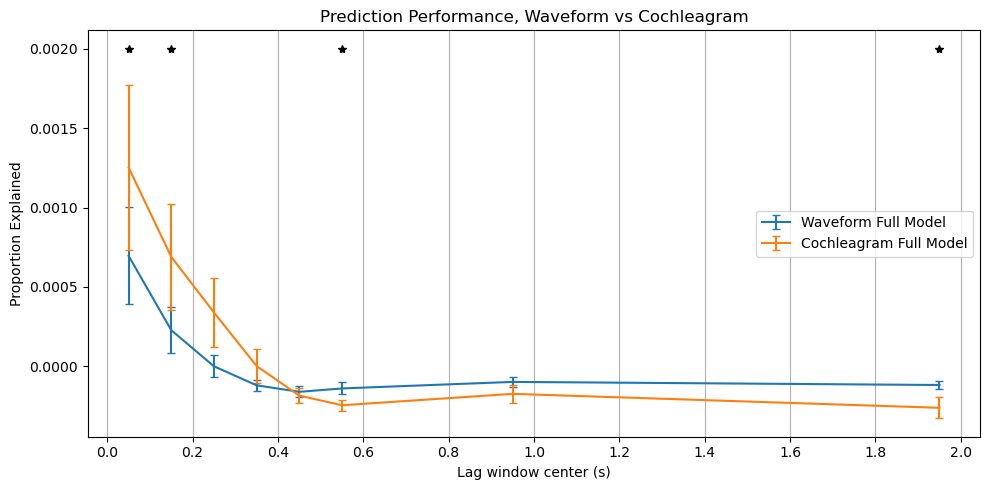

In [56]:
#----------------------# T-TEST #----------------------#
# Extract decoding performance 
cochFullRows = []

for subject in SUBJECTS:
    cochFullRow = []
    for tstart, tstop in RANGES:
        cochFullRow.append(cochleagramDecoders[subject][tstart]['full'].proportion_explained.mean())
        
    cochFullRows.append(cochFullRow)

# Subject x latency matrix
cochFullData = np.array(cochFullRows)

# Calculate t-statistics between the full and partial data
ttestCochWav = scipy.stats.ttest_rel(fullData, cochFullData, axis=0, nan_policy='omit') 

# Print stats
print("T-stats, Waveform vs. Cochleagram:", ttestCochWav.statistic)
print("P-values, Waveform vs. Cochleagram:", ttestCochWav.pvalue)


#----------------------# PLOTTING #----------------------#
# Define latency window centers for plotting
x = [(tstart + tstop) / 2 for tstart, tstop in RANGES]

# Compute means and error
waveformMean = fullData.mean(0)
waveformErr = scipy.stats.sem(fullData, axis=0, nan_policy='omit')
cochMean = cochFullData.mean(0)
cochErr = scipy.stats.sem(cochFullData, axis=0, nan_policy='omit')

plt.figure(figsize=(10, 5))
plt.errorbar(x, waveformMean, yerr=waveformErr, label='Waveform Full Model', capsize=3)
plt.errorbar(x, cochMean, yerr=cochErr, label='Cochleagram Full Model', capsize=3)

# Significant (p < 0.05) time-points
for i, xi in enumerate(x):
    if ttestCochWav.pvalue[i] < 0.05:
        plt.plot(xi, 0.002, marker='*', color='black') 
    

plt.xticks(np.arange(0, 2.1, 0.200))
plt.grid(axis='x')
plt.xlabel('Lag window center (s)')
plt.ylabel('Proportion Explained')
plt.title("Prediction Performance, Waveform vs Cochleagram")
plt.legend()
plt.tight_layout()
plt.show()

As we can see by the black stars (which indicate a p-value of less than 0.05), we have 4 time-points that have a statistically significatn difference between the cochleagram and waveform models. However, if we look at the t-statistics, we see that 2 of the valuable points are negative, indicating the waveform outpreformed the cochleagram, and 2 are positive, indicating the cochleagram outperformed the waveform. 

Since half of the points were not significantly different, and there are an even number that show either model is better at certain time points, we cannot conclude that either the waveform model nor the cochleagram model are better at predicting brain activity. 